<a href="https://colab.research.google.com/github/datajcthemax/playdata/blob/main/day27_GAN_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 27번째 이야기
- GAN
- CGAN

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# mnist image
image_shape = (1,28,28)
BATCH_SIZE = 1024
# 데이터셋 구성
transform = transforms.Compose([transforms.Resize(image_shape[-2:]),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5],[0.5]),                                
                                                  ])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform = transform)
dataloader = DataLoader(dataset, batch_size = BATCH_SIZE,shuffle=True)


In [ ]:
# Model 생성
# Generator
class Generator(nn.Module):
  def __init__(self, latent_dim, num_classes, image_shape):
    super().__init__()

    self.latent_dim= latent_dim
    self.label_emb = nn.Embedding(num_classes, latent_dim)

    self.model = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, int(image_shape[0]*image_shape[1]*image_shape[2])),
        nn.Tanh()
    )
  def forward(self, noise, labels):
    x = torch.mul(self.label_emb(labels), noise)
    x = self.model(x)
    return x.view(x.size(0), *image_shape)
    # return x.reshape(x.size(0), *image_shape)

In [ ]:
# Discriminator
class Discriminator(nn.Module):
  def __init__(self, num_classes, image_shape):
    super().__init__()
    self.label_emb = nn.Embedding(num_classes, int(image_shape[0]*image_shape[1]*image_shape[2])) # 1*28*28
    self.model = nn.Sequential(
        nn.Linear(int(image_shape[0]*image_shape[1]*image_shape[2])*2, 128),
        nn.ReLU(),
        nn.Linear(128, 1),
        nn.Sigmoid()
    )
  def forward(self, images, labels):
    x = torch.cat((images.view(images.size(0), -1), self.label_emb(labels)), -1)
    x = self.model(x)
    return x

In [ ]:
# hyper parameter
latent_dim = 100
num_classes = 10
num_epochs = 100
learning_rate = 1e-3 # LEARNING_RATE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# model
generator = Generator(latent_dim, num_classes, image_shape).to(device) # image_shape = (1,28,28)
discriminator = Discriminator(num_classes, image_shape).to(device)


In [ ]:
# loss function, optimizer
from torch import optim
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)

- 각 에폭마다 하나의 데이터를 받는 리스트
- 데이터는 이미지와 레이블
- 1. 시각화 how : 9개 이미지 보여주기, 에폭이 변할때마다 보여주기, 한에폭만 보여주고 지워지는 문제
- 2. 9회 이후부터는 매번 이미지가 변하는걸 보자

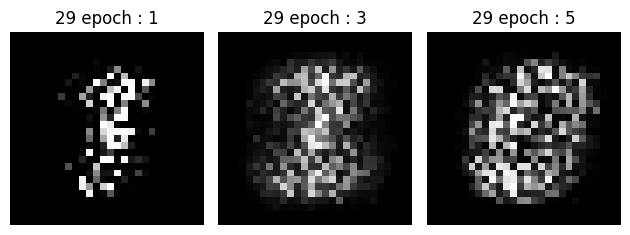

KeyboardInterrupt: ignored

In [ ]:
imgs_progress = []
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        real_labels = labels.to(device)

        # 진짜 데이터에 대한 손실 계산
        real_validity = discriminator(real_imgs, real_labels)
        real_loss = criterion(real_validity, torch.ones_like(real_validity))

        # 가짜 데이터 생성 및 손실 계산
        noise = torch.randn(BATCH_SIZE, latent_dim).to(device)
        gen_labels = torch.randint(0, num_classes, (BATCH_SIZE,)).to(device)
        gen_imgs = generator(noise, gen_labels)
        fake_validity = discriminator(gen_imgs.detach(), gen_labels)
        fake_loss = criterion(fake_validity, torch.zeros_like(fake_validity))

        # 판별자 손실 및 업데이트
        d_loss = real_loss + fake_loss
        optimizer_d.zero_grad()
        d_loss.backward()
        optimizer_d.step()

        # 생성자 손실 및 업데이트
        g_validity = discriminator(gen_imgs, gen_labels)
        g_loss = criterion(g_validity, torch.ones_like(g_validity))
        optimizer_g.zero_grad()
        g_loss.backward()
        optimizer_g.step()
    tmp_img = gen_imgs.cpu().detach().numpy()[0].squeeze(0)
    tmp_label = gen_labels[0].cpu().item()
    imgs_progress.append([tmp_img,tmp_label])
    show_num=3
    if len(imgs_progress)<show_num:continue
    clear_output()
    show_imgs = imgs_progress[-show_num:]
    for num in range(show_num):
      plt.subplot(1,show_num,num+1)
      plt.imshow(show_imgs[num][0], cmap='gray')
      plt.title(str(epoch)+" epoch : "+str(show_imgs[num][1]))
      plt.axis('off')
      plt.tight_layout()
    plt.show()
# 한번에 여러 이미지 나오도록 변경
# 코드를 자신의 스타일에 맞춰서 변형

# 에폭에 따라서 하나의 이미지가 변해가는 모습을 보여주고 싶다.
# 9장 보고 싶다

## DCGAN

Epoch [5/5], Loss D: 0.0673, Loss G: 3.0891


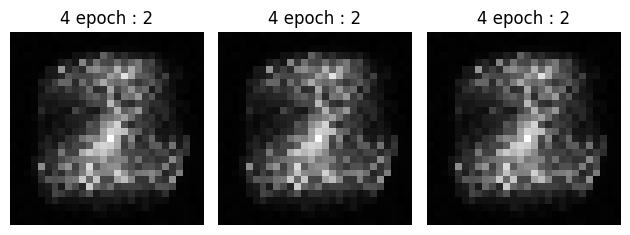

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# 생성자 (Generator)
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            self._block(channels_noise, features_g * 8, 4, 1, 0),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            self._block(features_g * 2, features_g, 4, 2, 1),
            nn.ConvTranspose2d(features_g, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(True),
        )

    def forward(self, x):
        return self.net(x)

# 판별자 (Discriminator)
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1, 0.2),
            self._block(features_d * 2, features_d * 4, 4, 2, 1, 0.2),
            self._block(features_d * 4, features_d * 8, 4, 2, 1, 0.2),
            nn.Conv2d(features_d * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding, alpha):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(alpha),
        )

    def forward(self, x):
        return self.net(x)

# 하이퍼파라미터 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.0002
batch_size = 64
image_size = 64
channels_img = 1
channels_noise = 256
num_epochs = 100
features_d = 16
features_g = 16

# 데이터 로딩
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="data/", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset,batch_size=batch_size, shuffle=True, num_workers=2)
generator = Generator(channels_noise, channels_img, features_g).to(device)
discriminator = Discriminator(channels_img, features_d).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

criterion = nn.BCELoss()

for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(dataloader):
        real = real.to(device)
        batch_size = real.shape[0]
        noise = torch.randn(batch_size, channels_noise, 1, 1).to(device)
            # 판별자 학습
        real_labels = torch.ones(batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
        
        real_output = discriminator(real).reshape(-1, 1, 1, 1)
        loss_D_real = criterion(real_output, real_labels)
        
        fake = generator(noise)
        fake_output = discriminator(fake.detach()).reshape(-1, 1, 1, 1)
        loss_D_fake = criterion(fake_output, fake_labels)
        
        loss_D = (loss_D_real + loss_D_fake) / 2
        discriminator.zero_grad()
        loss_D.backward()
        optimizer_D.step()
        
        # 생성자 학습
        output = discriminator(fake).reshape(-1, 1, 1, 1)
        loss_G = criterion(output, real_labels)
        
        generator.zero_grad()
        loss_G.backward()
        optimizer_G.step()
        
    tmp_img = gen_imgs.cpu().detach().numpy()[0].squeeze(0)
    tmp_label = gen_labels[0].cpu().item()
    imgs_progress.append([tmp_img,tmp_label])
    show_num=3
    if len(imgs_progress)<show_num:continue
    clear_output()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss D: {loss_D:.4f}, Loss G: {loss_G:.4f}")
    show_imgs = imgs_progress[-show_num:]
    for num in range(show_num):
      plt.subplot(1,show_num,num+1)
      plt.imshow(show_imgs[num][0], cmap='gray')
      plt.title(str(epoch)+" epoch : "+str(show_imgs[num][1]))
      plt.axis('off')
      plt.tight_layout()
    plt.show()
